In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

from scipy import stats
!pip install arviz
import arviz as az
import pystan

from theano import shared
from sklearn import preprocessing

     |████████████████████████████████| 1.3MB 2.9MB/s 
     |████████████████████████████████| 4.1MB 41.5MB/s 
     |████████████████████████████████| 307kB 42.6MB/s 


In [2]:
df = pd.read_csv('../input/mercari-price-suggestion-challenge/train.tsv', 
                  sep = '\t')

print(df.shape)
df.head()

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
df.isnull().sum()/len(df)

train_id             0.000000
name                 0.000000
item_condition_id    0.000000
category_name        0.004268
brand_name           0.426757
price                0.000000
shipping             0.000000
item_description     0.000003
dtype: float64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [5]:
# Random 1% sample of train
df = df.sample(frac = 0.01, random_state = 99)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 800927 to 20724
Data columns (total 8 columns):
train_id             14825 non-null int64
name                 14825 non-null object
item_condition_id    14825 non-null int64
category_name        14760 non-null object
brand_name           8567 non-null object
price                14825 non-null float64
shipping             14825 non-null int64
item_description     14825 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 1.0+ MB


In [6]:
df.isnull().sum()/len(df)

train_id             0.000000
name                 0.000000
item_condition_id    0.000000
category_name        0.004384
brand_name           0.422125
price                0.000000
shipping             0.000000
item_description     0.000000
dtype: float64

Independent variables = category_name, shipping

Label = price 

In [7]:
# Rid null
df = df[pd.notnull(df['category_name'])]

# Check unique
df.category_name.nunique()

689

In [8]:
df.category_name.value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings                 585
Women/Tops & Blouses/T-Shirts                                  454
Beauty/Makeup/Face                                             319
Beauty/Makeup/Lips                                             314
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    265
                                                              ... 
Home/Home Appliances/Humidifiers                                 1
Home/Home Décor/Baskets                                          1
Men/Sweaters/Full Zip                                            1
Vintage & Collectibles/Toy/Animal                                1
Handmade/Needlecraft/Supplies                                    1
Name: category_name, Length: 689, dtype: int64

Shipping
- 1 = paid by seller 
- 0 = paid by buyer

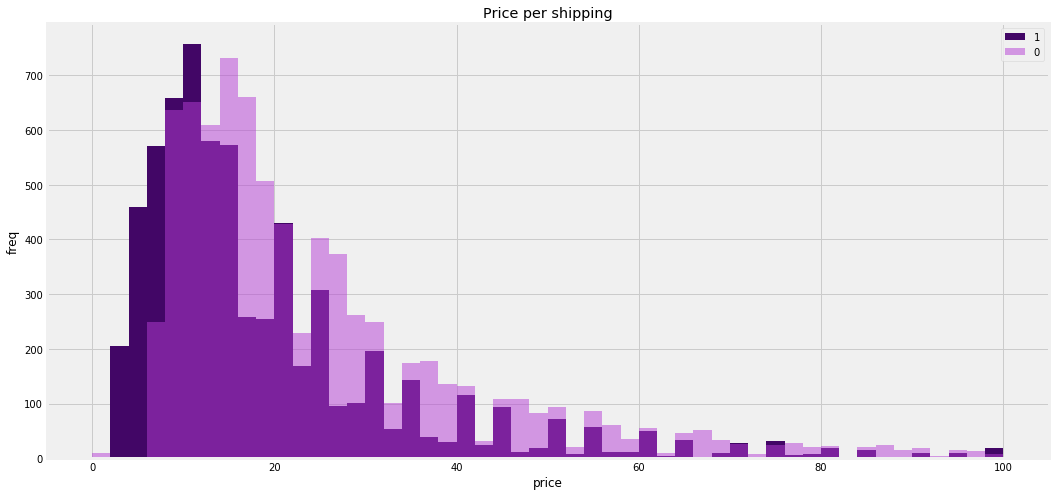

In [9]:
shipping_1 = df.loc[df['shipping'] == 1, 'price']
shipping_0 = df.loc[df['shipping'] == 0, 'price']

fig, ax = plt.subplots(figsize = (16, 8))

ax.hist(shipping_1, 
        color = '#420666', alpha = 1.0, 
        bins = 50, range = [0, 100], 
        label = 1)

ax.hist(shipping_0, 
        alpha = 0.5,color = '#B63ED5', 
        bins = 50, range = [0, 100],
        label = 0)

plt.xlabel('price', fontsize = 12)
plt.ylabel('freq', fontsize = 12)
plt.title('Price per shipping')
plt.legend()
plt.show();

buyer shipping > seller shipping

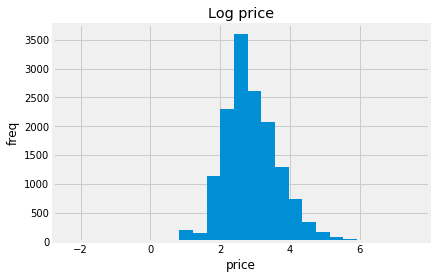

In [10]:
df.price.apply(lambda x: np.log(x + 0.1)).hist(bins = 25)

plt.title('Log price')
plt.xlabel('price')
plt.ylabel('freq');

# Local copies of variables 

In [11]:
le = preprocessing.LabelEncoder()

# Category_names
df['cat_code'] = le.fit_transform(df['category_name'])

cat_names = df.category_name.unique()
cats = len(cat_names)

cat = df['cat_code'].values

# Price
price = df.price
df['log_price'] = log_price = np.log(price + 0.1).values

# Shipping
shipping = df.shipping.values

cat_lookup = dict(zip(cat_names, 
                      range(len(cat_names))))

df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_code,log_price
800927,800927,Liz Lange maternity jeans FREE SHIP!!,3,Women/Maternity/Jeans,Liz Lange,14.0,1,"Awesome maternity jeans. No bad, just elastic ...",598,2.646175
1416912,1416912,Lipsense & Gift Certificate,1,Beauty/Makeup/Lips,SeneGence,45.0,1,I have mulled wine with glossy gloss! I am als...,24,3.808882
656218,656218,False Lash Effect Mascara ❤Freeship,1,Beauty/Makeup/Eyes,NaN,8.0,1,"Color Black New, Never Opened. Shipping out to...",22,2.091864
809542,809542,FEKKAI TECHNICIAN COLOR CARE,1,Beauty/Hair Care/Styling Products,NaN,4.0,1,New in box,18,1.410987
1455938,1455938,(20) 10x13 Yellow Flowers Poly Mailers,1,Other/Office supplies/Shipping Supplies,NaN,8.0,1,Such a gorgeous color and design. Ship your sa...,435,2.091864


# Pooled model

Complete pooling 

- treat all categories identically 
- estimate common price 
- mean of all categories

In [12]:
# x = shipping covariates
# y = log price 
# N = sample number 

# 3 data blocks 
pooled_data = '''
              data {
              int <lower = 0> N;
              vector[N] x; 
              vector[N] y;
              }
              '''
# sigma = error term 
# beta = log price given change in who pays shipping 
pooled_params = ''' 
                parameters {
                vector[2] beta;
                real <lower=0> sigma;
                }
                '''
# y = predicted log price of a product 
pooled_model = '''
               model {
               y ~ normal(beta[1] + beta[2] * x, 
               sigma); 
               }
               '''

In [13]:
# fit model 

# map Python variables to variables used in stan 
# pass data, parameters, model to stan 

pooled_data_dict = {'N': len(log_price),
                    'x': shipping,
                    'y': log_price}

stan = pystan.StanModel(model_code = pooled_data + pooled_params + pooled_model)

# 1000 iter = length 1000 
pooled_fit = stan.sampling(data = pooled_data_dict, iter = 1000, chains = 2) 

Permuted = True 
 - extract samples 
 - place into dict of arrays 
 - vis + summarize

Check mean values of parameter estimates from sampling 

In [14]:
pooled_sample = pooled_fit.extract(permuted = True)

# b0 = alpha 
# m0 = beta 
b0, m0 = pooled_sample['beta'].T.mean(1)

# alpha = mean 'common' price 
# beta = mean variation in price, given change in who pays shipping 
print('alpha: {0}, beta: {1}'.format(b0, m0))

alpha: 3.072841612693007, beta: -0.3677246205065428


Text(0, 0.5, 'log price')

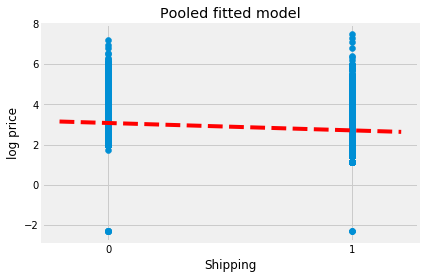

In [15]:
plt.scatter(df.shipping, np.log(df.price + 0.1))

x_val = np.linspace(-0.2, 1.2)

plt.xticks([0, 1])
plt.plot(x_val, 
         m0*x_val + b0,
         'r--') 
plt.title('Pooled fitted model')
plt.xlabel('Shipping')
plt.ylabel('log price')

- Outliers indicate original price varies significantly 
- Expect gradient of fitted line to vary according to different subsets of data 
- Possible substantial bias in estimate 
- Fitted line describes trend 

# Unpooled model

- treat category independently 
- considers price of a product *x* within category *y* 
- category-level mean estimataion


In [16]:
# 689 unique categories

# x = shipping covariate 
# y = log price 
# N = sample numbers 

# 3 data blocks 

unpooled_data = ''' 
                 data {
                 int <lower = 0> N;
                 int <lower = 1, upper = 689> category[N];
                 vector[N] x; 
                 vector[N] y;
                 }'''

unpooled_params = '''
                      parameters {
                      vector[689] a;
                      real beta;
                      real <lower = 0, upper = 100> sigma; 
                      }
                      transformed parameters {
                      vector[N] y_hat;
                          for (i in 1:N)
                          y_hat[i] <- beta * x[i] + a[category[i]];
                      }'''

unpooled_model = '''
                 model {
                 y ~ normal(y_hat, sigma);
                 }'''


In [17]:
# map Python variables to variables used in stan 
# pass data, parameters (transformed, untransformed), model to stan 

unpooled_data_dict = {'N': len(log_price),
                      'category': cat+1, 
                      'x': shipping,
                      'y': log_price}

stan = pystan.StanModel(model_code = unpooled_data + unpooled_params + unpooled_model)
unpooled_fit = stan.sampling(data = unpooled_data_dict, iter = 1000, chains = 2)

In [18]:
unpooled_estimates = pd.Series(unpooled_fit['a'].mean(0), 
                               index = cat_names)

unpooled_std =pd.Series(unpooled_fit['a'].std(0), 
                        index = cat_names)

In [19]:
unpooled_estimates[:20]

Women/Maternity/Jeans                                          2.717267
Beauty/Makeup/Lips                                             2.992204
Beauty/Makeup/Eyes                                             2.777525
Beauty/Hair Care/Styling Products                              2.897780
Other/Office supplies/Shipping Supplies                        2.771513
Women/Women's Accessories/Wallets                              3.001299
Women/Jewelry/Necklaces                                        1.938908
Kids/Toys/Stuffed Animals & Plush                              3.197631
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    2.997616
Men/Men's Accessories/Ties                                     2.971408
Handmade/Music/Vinyl                                           2.946397
Vintage & Collectibles/Collectibles/Figurine                   2.631136
Kids/Bathing & Skin Care/Skin Care                             2.575495
Women/Athletic Apparel/Pants, Tights, Leggings                 3

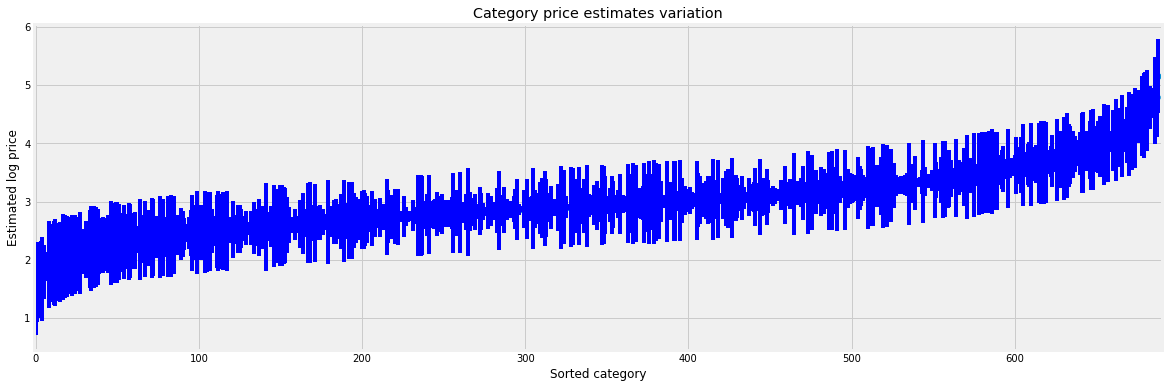

In [20]:
sort = unpooled_estimates.sort_values().index

plt.figure(figsize = (18, 6))
plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[sort])
for i, m, se in zip(range(len(unpooled_estimates)), 
                    unpooled_estimates[sort], 
                    unpooled_std[sort]):
    plt.plot([i,i], [m-se, m+se], 'b-') 
    plt.xlim(-1,690); 
    
plt.ylabel('Estimated log price');plt.xlabel('Sorted category');plt.title('Category price estimates variation');

- Showing categories with relatively low and high price estimations
- Not captured in single price estimation 

# Comparison 

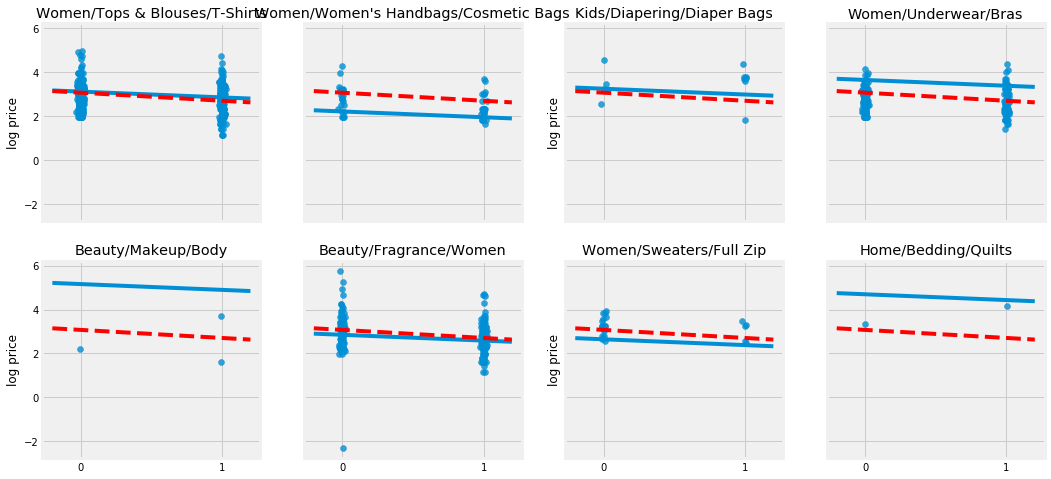

In [21]:
# Define cat subset 
sample_cat = ('Women/Tops & Blouses/T-Shirts', "Women/Women's Handbags/Cosmetic Bags", 
              'Kids/Diapering/Diaper Bags', 'Women/Underwear/Bras', 
              'Beauty/Makeup/Body', 'Beauty/Fragrance/Women', 
              'Women/Sweaters/Full Zip', 'Home/Bedding/Quilts')

fig, axes = plt.subplots(2, 4, 
                         figsize = (16, 8), 
                         sharex = True, sharey = True)

axes = axes.ravel()

a = unpooled_fit['beta'].mean(0)

for i, c in enumerate(sample_cat):
    x = df.shipping[df.category_name == c]
    y = df.log_price[df.category_name == c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha = 0.8)
    
    b = unpooled_estimates[c]
    
    # Plot 
    x_val = np.linspace(-0.2, 1.2) 
    axes[i].plot(x_val, a*x_val+b) # unpooled model
    axes[i].plot(x_val, m0*x_val+b0, 'r--') # pooled
    axes[i].set_xticks([0, 1])
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log price')

# Red dashed = pooled 
- identical for all categories 
- indicating pooling is not useful 

# Blue = unpooled fitted estimate 
- estimates track observations closely = potential overfitting 
- estimates produced through few observations = unreliable 

# Partial Pooling 
- estimate price only 
- ignore other predictors (shipping) 

- approximate weighted avg of unpooled category and pooled estimates


In [22]:
# data block 

# a = vector of overall price for each category

# mu_a = mean price of distribution from which category levels are drawn from

# sigma_a = std of price distribution of category / variation of category means around avg
 
# sigma_y = estimation std / sampling error / residual error of observations 

partial = ''' 
          data {
              int <lower = 0> N;
              int <lower = 1, upper = 689> category[N];
              vector[N] y;
          }
          parameters {
              vector[689] a;
              real mu_a;
              real <lower = 0, upper = 100> sigma_a;
              real <lower = 0, upper = 100> sigma_y;
          }
          transformed parameters {
              vector[N] y_hat;
              for (i in 1:N)
                  y_hat[i] <- a[category[i]];
          }
          model {
              mu_a ~ normal(0, 1);
              a ~ normal(10 * mu_a, sigma_a);
              y ~ normal(y_hat, sigma_y);
          }'''

In [23]:
partial_pool_dict = {'N': len(log_price), 
                     'category': cat + 1,
                     'y': log_price}

stan = pystan.StanModel(model_code = partial)
partial_pool_fit = stan.sampling(data = partial_pool_dict, 
                                 iter = 1000, chains = 2)

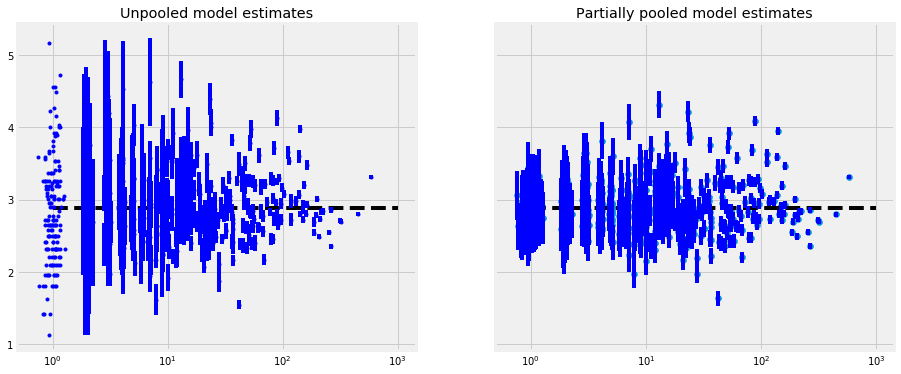

In [24]:
# Check category-level price estimates
    # view sample estimates for 'a'
sample_trace = partial_pool_fit['a']

fig, axes = plt.subplots(1, 2, figsize = (14, 6), 
                         sharex = True, sharey = True)

samples, cats = sample_trace.shape
jitter = np.random.normal(scale = 0.1, size=cats)

n_category = df.groupby('category_name')['train_id'].count()
unpooled_means = df.groupby('category_name')['log_price'].mean()
unpooled_sd = df.groupby('category_name')['log_price'].std()
unpooled = pd.DataFrame({'n':n_category, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 1, 1000, linestyles='--')

samples, categories = sample_trace.shape
means = sample_trace.mean(axis = 0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_category.values + jitter, means)
axes[1].set_xscale('log')
# axes[1].set_xlim(100,1000)
# axes[1].set_ylim(2, 4)
axes[1].hlines(sample_trace.mean(), 1, 1000, linestyles = '--')
for j,n,m,s in zip(jitter, n_category.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-');
    
axes[0].set_title("Unpooled model estimates")
axes[1].set_title("Partially pooled model estimates");

# Multilevel modelling 
- allows parameter distribution to be shared across categories 
- allows reasonable estimation of parameters with few observations

Varying-slope multilevel Model 
- using partial pooling 
- using varying intercept 
- common distribution for category-level price = information on likely price levels 
- categories with few observations should be less extreme ****

In [25]:
# data block 

# J = number of categories 
# N = number of samples 

# (vector) a = vector of overall price in each category (one value per category)
# (real value) b = effect of who pays shipping 

# mu_a = underlying mean price of distribution 

# sigma_a = std of underlying mean price 
# sigma_y = residual error 

varcept = '''
          data {
              int <lower = 0> J;
              int <lower = 0> N;
              int <lower = 1, upper = J> category[N];
              vector[N] x;
              vector[N] y;
          }
          parameters {
              vector[J] a;
              real b;
              real mu_a;
              real <lower = 0, upper = 100> sigma_a;
              real <lower = 0, upper = 100> sigma_y;
          }
          transformed parameters {
              vector[N] y_hat;
              for (i in 1:N)
                  y_hat[i] <- a[category[i]] + x[i] * b;
          }
          model {
              sigma_a ~ uniform(0, 100);
              a ~ normal(mu_a, sigma_a);
              b ~ normal(0, 1);
              sigma_y ~ uniform(0, 100);
              y ~ normal(y_hat, sigma_y);
          }'''

In [26]:
varcept_dict = {'N': len(log_price),
                'J': len(n_category),
                'category': cat+1,
                'x': shipping,
                'y': log_price}

stan = pystan.StanModel(model_code = varcept)
varcept_fit = stan.sampling(data = varcept_dict, 
                            iter = 1000, chains = 2)

a = intercept of model (overall price in each category)

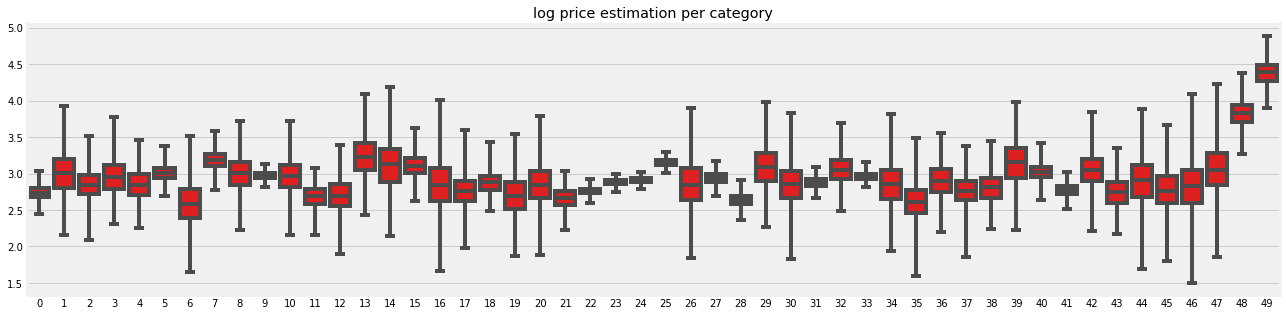

In [27]:
# Collect category-level estimates of overall price
sample_a = pd.DataFrame(varcept_fit['a'])

plt.figure(figsize = (20, 5))

# Vis first 50 indexed cats 
g = sns.boxplot(data = sample_a.iloc[:, 0:50], 
                whis = np.inf, color = 'r')

g.set_title('log price estimation per category')

g; 

Large variation in price by category 

Param estimation distribution 
- sigma_a (variation of category mean price around avg)
- beta (shipping coefficient)

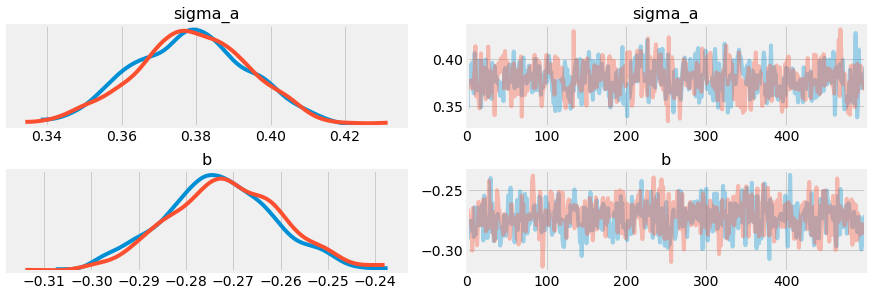

In [28]:
az.plot_trace(varcept_fit, var_names = ['sigma_a', 'b']);

In [29]:
# shipping coefficient 
varcept_fit['b'].mean()

-0.2725368968827975

- -0.27 interpretation:
products with shipping fee paid by seller is approx. 0.76 of the price of products with buyer-paid shipping, given the category. 

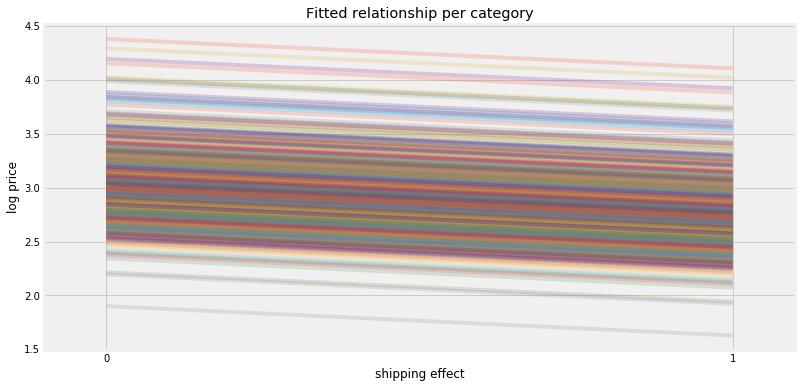

In [30]:
plt.figure(figsize = (12, 6))
x_val = np.arange(2)
catcept = varcept_fit['a'].mean(axis = 0) 
shipslope = varcept_fit['b'].mean()

for bi in catcept:
    plt.plot(x_val, shipslope*x_val + bi, alpha = 0.2)
    
plt.xlim(-0.1, 1.1)
plt.xticks([0, 1])
plt.title('Fitted relationship per category')
plt.xlabel('shipping effect')
plt.ylabel('log price');

- shipping effect fitted identically to previous models, but with different price level per category

- Majority of categories form a bulk of similar fits 

# Varying Slope 
- model on shipping to determine price 
- vector = b 
- real = a 

In [31]:
# a = prevailing site-wide price level 
# b = vector of shipping effects on each category 

# mu_b = mean shipping effect underpinning distribution from which category levels are drawn

# sigma_b = std of shipping effect distribution 
# sigma_y = residual error of observations 

varslope = '''
           data {
               int <lower = 0> J;
               int <lower = 0> N;
               int <lower = 1, upper = J> category[N];
               vector[N] x;
               vector[N] y;
           }
           parameters {
               real a;
               vector[J] b;
               real mu_b;
               real <lower = 0, upper = 100> sigma_b;
               real <lower = 0, upper = 100> sigma_y;
           }
           transformed parameters {
               vector[N] y_hat;
               for (i in 1:N)
                   y_hat[i] <- a + x[i] * b[category[i]];
           }
           model {
               sigma_b ~ uniform(0, 100);
               b ~ normal(mu_b, sigma_b);
               a ~ normal(0, 1);
               sigma_y ~ uniform(0, 100);
               y ~ normal(y_hat, sigma_y);
           }
           '''

In [32]:
varslope_dict = {'N': len(log_price), 
                 'J': len(n_category),
                 'category': cat+1,
                 'x': shipping,
                 'y': log_price}

stan = pystan.StanModel(model_code = varslope)
varslope_fit = stan.sampling(data = varslope_dict, 
                             iter = 1000, chains = 2)

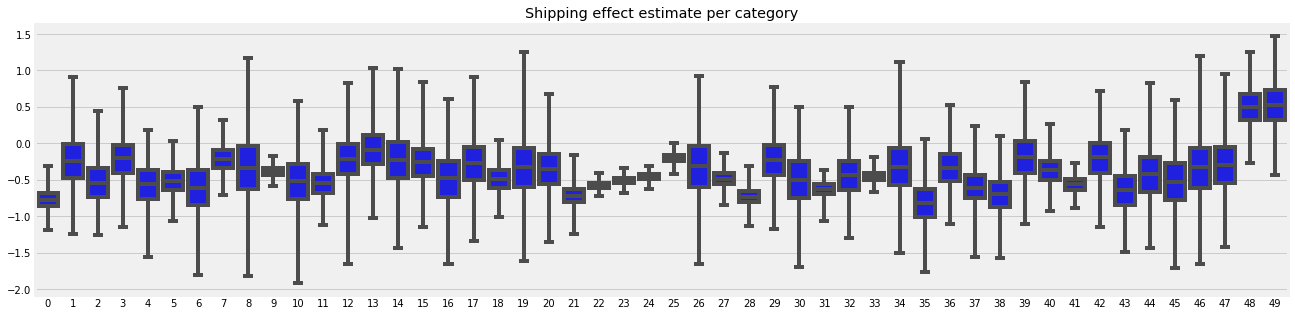

In [33]:
sample_b = pd.DataFrame(varslope_fit['b'])
plt.figure(figsize = (20, 5))
g = sns.boxplot(data = sample_b.iloc[:, 0:50], whis = np.inf, color = 'b')
g.set_title('Shipping effect estimate per category')
g;

median estimates smaller than varcept 
uncertainty range still large in categories with few observations 

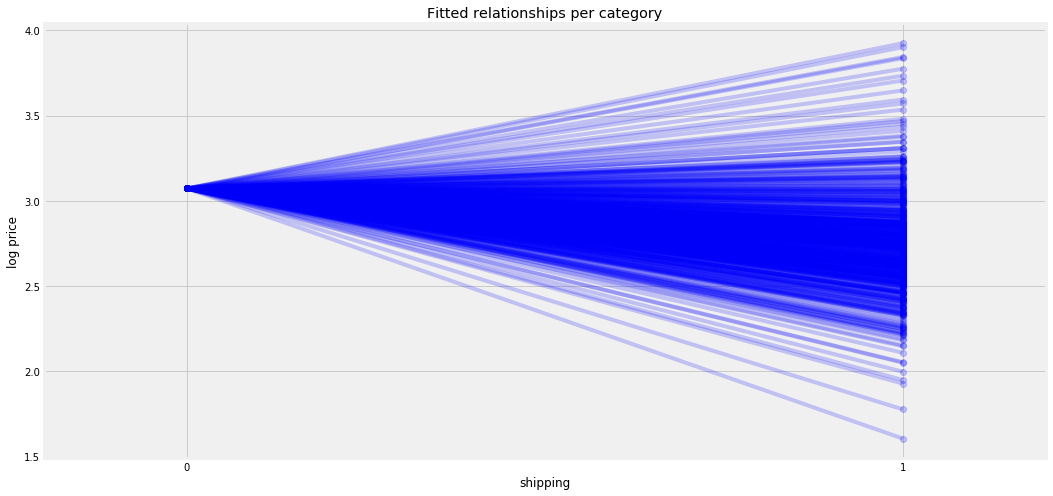

In [34]:
plt.figure(figsize = (16, 8))
x_vals = np.arange(2)

b = varslope_fit['a'].mean() # intercept 
m = varslope_fit['b'].mean(axis = 0) # slope 

for mi in m:
    plt.plot(x_vals, mi*x_vals + b, 'bo-', alpha = 0.2)

plt.xlim(-0.2, 1.2)
plt.xticks([0, 1])
plt.title('Fitted relationships per category')
plt.xlabel('shipping')
plt.ylabel('log price');

- fitted identical price level to each category 
- different shipping effect in each category 
- shipping have very small effect on 2 categories 
- Majority of categories form a bulk 